In [6]:
import prosail
import numpy as np
import matplotlib.pyplot as plt
import numba
plt.rcParams['figure.figsize'] = (14, 14)

### Biophysical parameter estimation -  Maximum Likelihood optimization problem. 

##### Alfonso Diz-Lois dizlois@gmail.com

The goal here is to implement a maximum likelihood estimator (MLE) for the parameters of a non-linear observational operator $H(x)$ given some observations $y$ whose error is assumed to be normally distributed  $N\left(0,\sigma\right)$ :

$$P(y\mid x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{ - \frac{\left( {H(x) - y_{obs} } \right)^2 }{2\sigma ^2 }}$$

In this example, the observational operator will be the transformation of several inputs(LAI,CAB,etc..) into a Sentinel2 observation by using the [PROSAIL model](https://github.com/jgomezdans/prosail) and [the Spectral Response Functions of the bands of interest](https://github.com/jgomezdans/MULTIPLY_MCMC_explore/blob/master/S2A_SRS.csv). 

$y$ represents a Sentinel2 sample and LAI (Leave Area Index) will be the unknown parameter $x$

Maximizing $P\left( y\mid x \right))$ is equivalent to minimizing its -log function:



$$
J(x)=\sum \frac{\left ( H(x)-y_{obs} \right )^{2}}{2\sigma^{2}}
$$


The numerator represents the residuals squared, while the denominator weights them in terms of the variance of the observation which is quite intuitive.

Scipy.optimize is finally used in order to find the minimum of our function and therefore, the "most likely" value of LAI.

### Creating synthetic observations $y$....

First of all, we need some observations for our estimates to be compared with. 

To this end, a synthetic spectrum is generated using PROSAIL. Parameters are fixed (LAI=3).

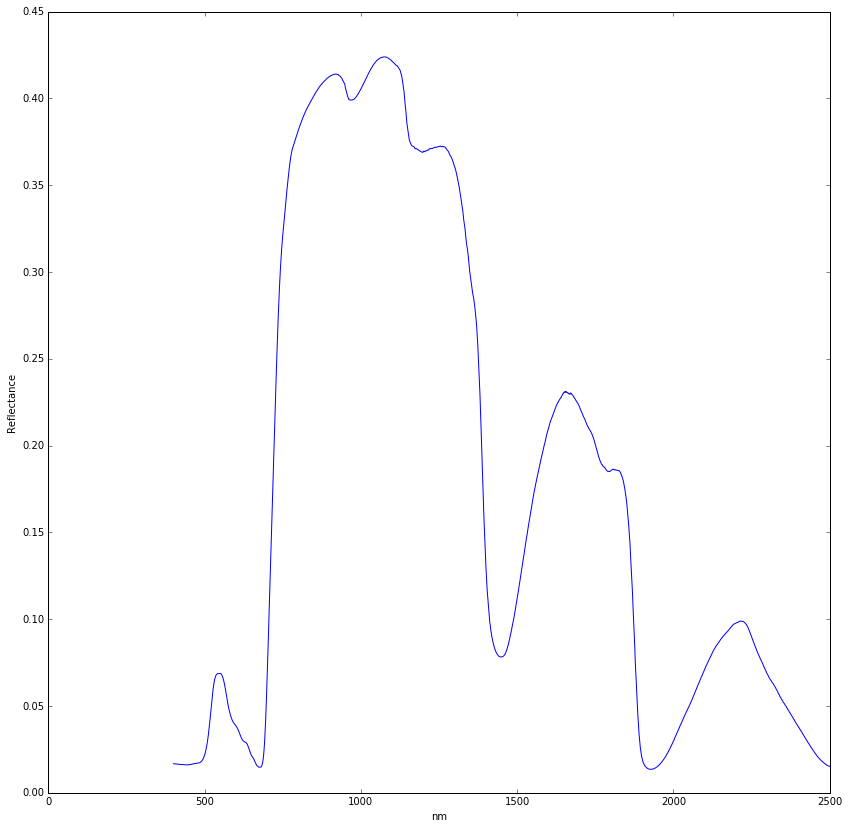

In [42]:
# define the model parameters here
n = 1.8
cab = 37.
car = 8.
cbrown = 0.3
cw = 0.013
cm = 0.005
lai = 3.
lidfa = 45.


# assuming black soil
rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))

# plot to check it looks sensible
wv = np.arange(400, 2501)
_ = plt.plot(wv, rho)
plt.xlabel("nm")
plt.ylabel("Reflectance")


Next step is to scale each band range using Sentinel2A SRS.
Given the nature of the PROSAIL model (mostly vegetation-related), only some bands are included.
We can see some examples of the effect of the transformation.


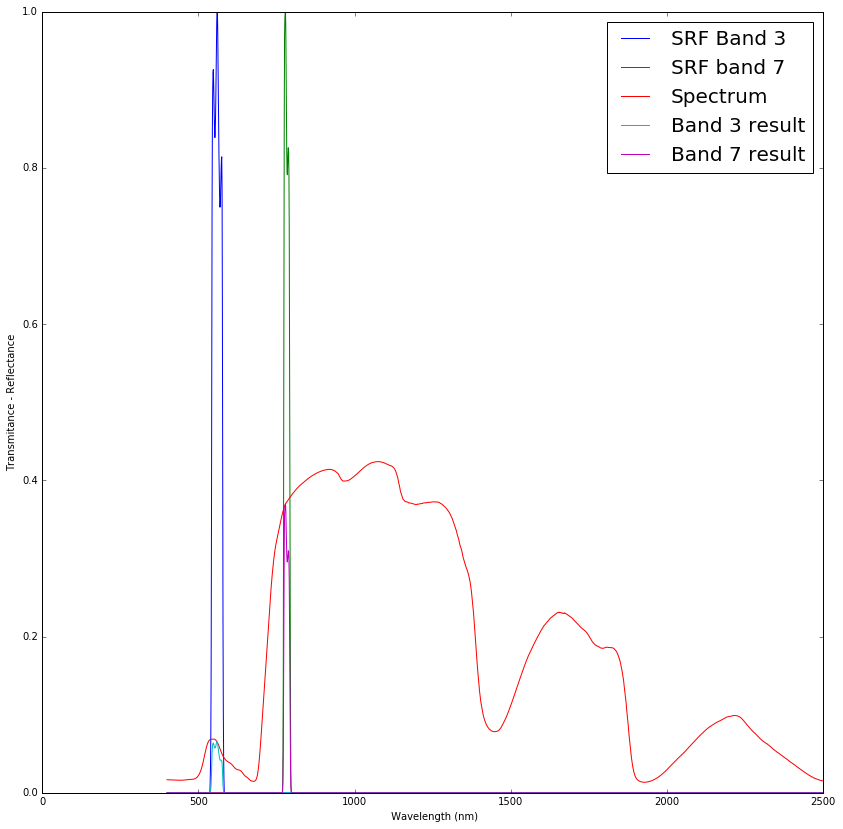

In [43]:
srf = np.loadtxt("./MULTIPLY_MCMC_explore/S2A_SRS.csv", skiprows=1, delimiter=",")[100:, :]
#Bands of interest
srf_land = srf[:, [1, 2, 3, 4, 5, 6, 7, 8, 11, 12]]
wv_land = np.array([486.0, 560.5, 665.0, 704.5, 740.0, 783.0,
                    838.84, 863.25, 1610.5, 2199.0])
# Apply the SRF to the data simulated above
rho_s2a = (rho[:, None]*srf_land)


#Example, band 3
plt.plot(srf[:,0],srf[:,3],label="SRF Band 3")
plt.plot(srf[:,0],srf[:,7],label="SRF band 7")
plt.plot(srf[:,0],rho,label="Spectrum")
plt.plot(srf[:,0],rho_s2a[:,2],label="Band 3 result")
plt.plot(srf[:,0],rho_s2a[:,6],label="Band 7 result")
plt.legend(loc='upper right',prop={'size': 20})
plt.xlabel(" Wavelength (nm)")
plt.ylabel("Transmitance - Reflectance")
plt.show()

In order to make our sample more "real", some gaussian noise (10%) is added. 

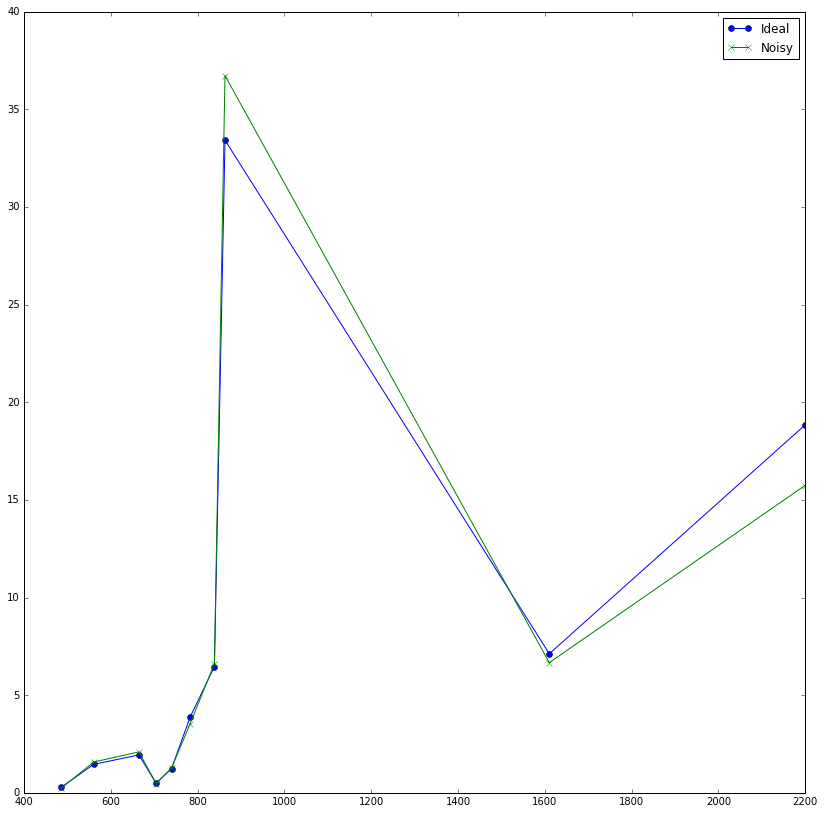

In [18]:
#Integration...
rho_s2a = rho_s2a.sum(axis=0)

# Add some grotty noise 10 % Normal distribution
rho_s2a_noise = rho_s2a + rho_s2a*0.1*np.random.randn(10)

# Plot stuff
plt.plot( wv_land, rho_s2a, 'o-', label="Ideal")
plt.plot( wv_land, rho_s2a_noise, '-x', label="Noisy")
plt.legend(loc="best")

The last step is to infer the unknown parameter $x$ (LAI) from our observation by minimizing the cost function $J(x)$. Note that there is no analytic solution to the derivative of the PROSAIL model with respect to the parameters, so the optimization must be performed graphically (Nelder-Mead algorithm performed well in this simple example).


Optimization terminated successfully.
         Current function value: 5.055332
         Iterations: 41
         Function evaluations: 84
[ 2.68575101]


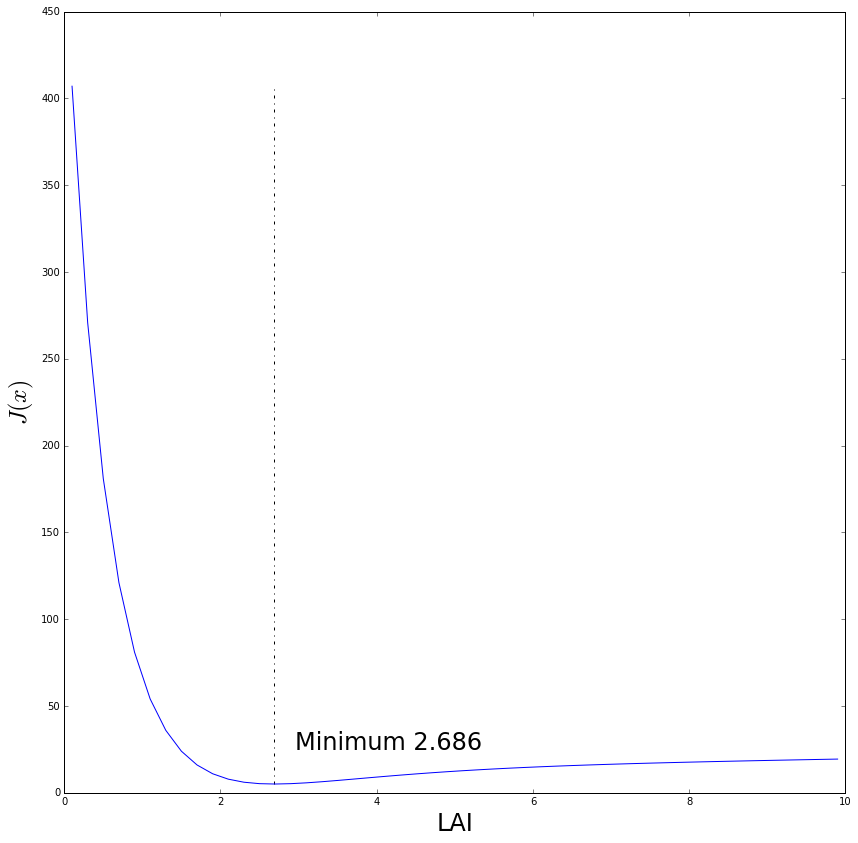

In [31]:
import scipy.optimize

#COST FUNCTION

def cost(lai_input):
    
    '''
    Return J at x
    '''
    # define the model parameters here for reasonably easy update
    lai_input=lai_input[0]
    # run the model forward. rsoil0 is the soil albedo array
    # assuming black soil
    rho = prosail.run_prosail(n, cab, car, cbrown, cw, cm, lai_input, lidfa, 
                    0.01, 30., 0., 0.,
                    prospect_version='D',
                    rsoil0=np.zeros(2101))
    
    # Apply SRFs
    rho_pred = (rho[:, None]*srf_land).sum(axis=0)
    # Residual predicted - measrued
    
    xx = rho_pred - rho_s2a_noise
    # Figure out noise. 
    sigma_obs = 0.1*rho_s2a_noise
    return (0.5*xx**2/sigma_obs**2).sum()

# starting guess
x0=0.
#Optimization
res = scipy.optimize.minimize(cost, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
#Solution
print(res.x)

#Cost function plot...
x=np.arange(0.1,10,0.2)
cost_=[]
for i in x:
    cost_.append(cost([i]))
plt.plot(x,cost_)
plt.xlabel("LAI",fontsize=24)
plt.ylabel("$J(x)$",fontsize=24)
plt.vlines(res.x,min(cost_),max(cost_),linestyles= 'dashdot')
plt.text(res.x*1.1,min(cost_)+20,"Minimum "+str(round(res.x[0],3)),fontsize=24)

plt.show()

A minimum was found at 2.686. Let's take a look at the shape of the probability distribution of our unknown parameter ($exp(-J(x))$)

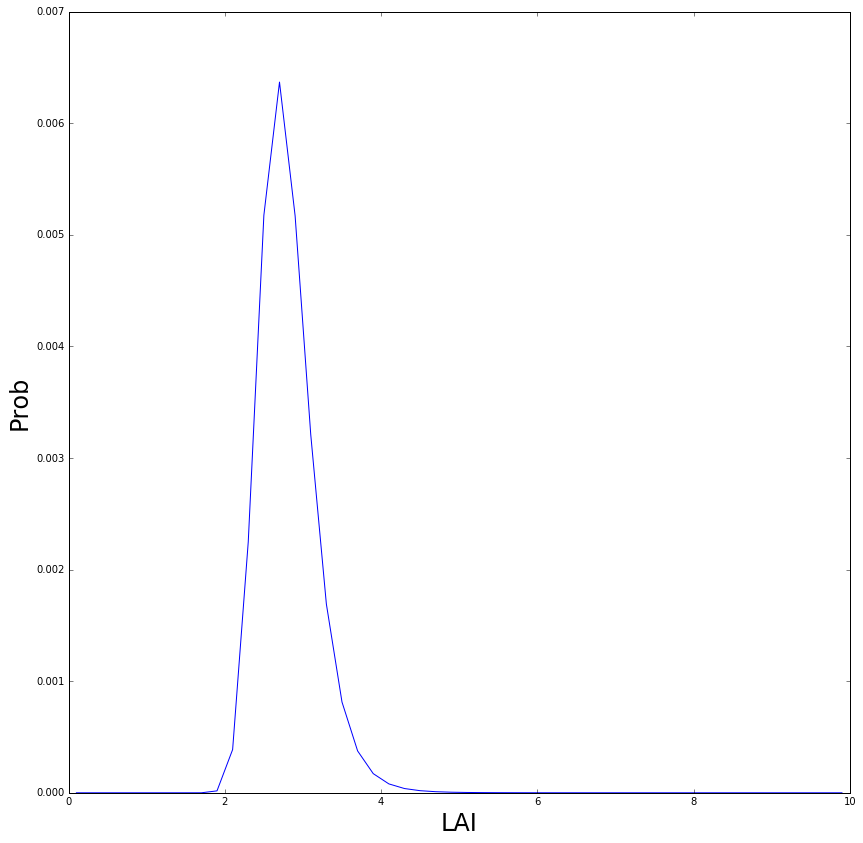

In [37]:
sigma_obs= 0.1*rho_s2a_noise
plt.plot(x,np.exp(-np.asarray(cost_)))
plt.ylabel("Prob",fontsize=24)
plt.xlabel("LAI",fontsize=24)
plt.show()

* Note that the pdf in the previous graph is not normalized and therefore do not integrate to 1.

Key points:

* Depending on the complexity of the observational model, iterations can take a while to run. Large models may require the use of emulators.
* Sometimes finding the minimum of our cost function may not be possible. Ill-posed problems can, for example, reach the minimum value at more than one x-value. 
* In such cases, extra information in the form of a  <i> a priori </i> distribution can help us to find the optimal solution. Other optimization method may be considered such as MonteCarloMarkovChains (MCMC).    